<a href="https://colab.research.google.com/github/cristinakuo/thesis-pre-research/blob/master/MLP_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Montaje de Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import tqdm

print(torch.cuda.is_available())

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

device = torch.device(dev)  

True


## Carga de datos: Coeficientes cepstrum con 10 ventanas de contexto

# Lectura de los archivos out_lab_fea_xx.pkl

 - Cada archivo contiene los datos de train, dev y test.
 - Se asume que dichos archivos se encuentran en un directorio llamado data en el directorio de ejecución
 - Los datos que contiene cada archivo (supongamos que sea el archivo con datos de train) son:
     - `data_name_train` Contiene el nombre del archivo de TIMIT que corresponde a cada frase
     - `data_set_train` Es un array de numpy. Cada fila contiene los coeficientes de un frame de una frase y de los cw_l y cw_r anteriores y posteriores al frame actual. Además la última columna contiene la etiqueta con el número de fonema de los 61 fonemas posibles al que corresponde (0-60). Para distinguir a que frase corresponde cada frame se usa `data_end_index_train`.
     - `data_end_index_train` Es un vector de numpy que indica la fila de `data_set_train` que corresponde al primer frame de la siguiente frase (eg. si fuera `data_end_index_train = [308,650...]` significaría que la primera frase se encuentra entre las filas 0 y 307 de la `matriz data_set_train` y la segunda entre la 308 y la 649. 
     - `fea_dict_train`. Es un diccionario que se usa para pasar información al kaldi. De acá el ancho de las ventanas de contexto `cw_l = fea_dict_train['mfcc'][3]` y `cw_r = fea_dict_train['mfcc'][4]`. También contiene el tamaño de las features y si hubiera mas features además de mfcc serían otras keys del diccionario.
     - `lab_dict_train`. No se usa de momento
     - `todo_train`. Vale `train`, `test`, o `dev` 


In [ ]:
# Load files: out_lab_fea_xx.pkl
# Saves the dictionary total_set in 3 files 
# that should contain train, dev and test data (in any order)

import pickle
import numpy as np

# Directorio de salida
tipo = ''
out_folder = '/content/gdrive/My Drive/Tesis/data/'
xi = 0 # Esto indica el nombre de los tres archivos (train, dev y test) 
xf = 3

total_set = dict()
for i in range(xi,xf):
    idf = str(i)
    out_file = 'out_lab_fea_' + idf + '.pkl'

    with open(out_folder+out_file,'rb') as f:
        total = pickle.load(f)
    total_set[total[5]] = total
    
data_name_train = total_set['train'][0]
data_end_index_train = total_set['train'][1]
fea_dict_train = total_set['train'][2]
lab_dict_train = total_set['train'][3]
data_set_train = total_set['train'][4]
todo_train = total_set['train'][5]

data_name_dev = total_set['dev'][0]
data_end_index_dev = total_set['dev'][1]
fea_dict_dev = total_set['dev'][2]
lab_dict_dev = total_set['dev'][3]
data_set_dev = total_set['dev'][4]
todo_dev = total_set['dev'][5]

data_name_test = total_set['test'][0]
data_end_index_test = total_set['test'][1]
fea_dict_test = total_set['test'][2]
lab_dict_test = total_set['test'][3]
data_set_test = total_set['test'][4]
todo_test = total_set['test'][5]

## Ordenar los datos

In [ ]:
nr_phrases_train = len(data_name_train)
nr_phrases_test = len(data_name_test)

print('Nr of phrases (train): ', nr_phrases_train)
print('Nr of phrases (test): ', nr_phrases_test)

data_set_train_phrases = np.split(data_set_train, data_end_index_train)[:-1] # Last item is empty
data_set_test_phrases = np.split(data_set_test, data_end_index_test)[:-1]

print('Train: split data into {} phrases.'.format(len(data_set_train_phrases)))
print('Test: split data into {} phrases.'.format(len(data_set_test_phrases)))

Nr of phrases (train):  3696
Nr of phrases (test):  192
Train: split data into 3696 phrases.
Test: split data into 192 phrases.


In [ ]:
# Divide data into input (x) y output (y)
x_train = [data_set_train[:,:-1] for data_set_train in data_set_train_phrases]
y_train = [data_set_train[:,-1].transpose() for data_set_train in data_set_train_phrases]
x_test = [data_set_test[:,:-1] for data_set_test in data_set_test_phrases]
y_test = [data_set_test[:,-1].transpose() for data_set_test in data_set_test_phrases]

# Transform to tensor
x_train = [torch.from_numpy(phrase).requires_grad_().type(torch.FloatTensor) for phrase in x_train]
y_train = [torch.from_numpy(phrase).type(torch.LongTensor) for phrase in y_train]
x_test = [torch.from_numpy(phrase).requires_grad_().type(torch.FloatTensor) for phrase in x_test]
y_test = [torch.from_numpy(phrase).type(torch.LongTensor) for phrase in y_test]

# Save in Device
x_train = [phrase.to(device) for phrase in x_train]
y_train = [phrase.to(device) for phrase in y_train]
x_test = [phrase.to(device) for phrase in x_test]
y_test = [phrase.to(device) for phrase in y_test]

# Get size of tran and test set
train_size = len(x_train)
test_size = len(x_test)

print("--Train data")
print("Number of samples: ", train_size)

print("--Test data")
print("Number of samples: ", test_size)

--Train data
Number of samples:  3696
--Test data
Number of samples:  192


## Definir la clase MLP

In [ ]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MultiLayerPerceptron, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size

    # Hidden layer
    self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size, bias=True)
    self.sigmoid = torch.nn.Sigmoid()
    
    # Output Layer
    self.fc2 = torch.nn.Linear(self.hidden_size, self.output_size, bias=True)
    #self.softmax = torch.nn.Softmax(dim=1) # Maybe unnecessary

  def forward(self, x):
    hidden_in = self.fc1(x).to(device)
    hidden_in = self.sigmoid(hidden_in).to(device)
    out = self.fc2(hidden_in).to(device)
    #output = self.softmax(hidden_out) # It's already done in CrossEntropy Function as LogSoftMax
    return out

## Instanciar un modelo MLP

In [ ]:
NR_PHONEMES = 61
input_size = x_train[0].shape[1] # Number of coefficients
hidden_size = 250 # Specified by Graves
output_size = NR_PHONEMES # Number of phonemes


print("Creating MLP model with parameters:")
print("Input size: ", input_size)
print("Hidden size: ", hidden_size)
print("Output size: ", output_size)

model = MultiLayerPerceptron(input_size, hidden_size, output_size)
model = model.to(device)

Creating MLP model with parameters:
Input size:  273
Hidden size:  250
Output size:  61


In [ ]:
learning_rate = 10e-5 # Specified by Graves
momentum = 0.9

cost_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

Ver Loss antes de entrenar

In [ ]:
# See the loss before training
model.eval()

total_loss = 0
nr_correct_frames = 0
nr_total_frames = 0
for (x_test_phrase, y_test_phrase) in zip(x_test, y_test):
  output_test = model(x_test_phrase)
  total_loss += cost_function(output_test, y_test_phrase)

  # Correct samples
  y_prediction_test = torch.argmax(output_test, dim=1)
  nr_correct_frames += int((y_prediction_test == y_test_phrase).sum())
  nr_total_frames += len(y_test_phrase)

before_train_loss = total_loss/test_size
print('Before train Loss:', before_train_loss.item())

perc_correct = nr_correct_frames/nr_total_frames*100
print("Correct frames percentage: ", perc_correct)


Before train Loss: 4.132086277008057
Correct frames percentage:  1.525069517608249


### Training time

In [ ]:
import time

nr_epochs = 400
epoch_losses_train = []
epoch_losses_test = []
epoch_correct_frames_train = []
epoch_correct_frames_test = []

start_time = time.time()
# TODO: initial weights? Graves: from flat distribution between -0.1 and 0.1
for epoch in range(nr_epochs):
  print(f'EPOCH #{epoch+1}')
  #=========Train ==============#
  model.train()
  # Variables used to get the percentage of correct frames
  nr_correct_frames = 0
  nr_total_frames = 0

  epoch_total_loss = 0

  # Randomize the order of phrases for each epoch
  random_idxs = np.random.permutation(train_size)
  
  for i in tqdm.notebook.tqdm(random_idxs):
    # Forward pass
    y_pred = model(x_train[i])
    
    # Compute loss
    loss = cost_function(y_pred, y_train[i])
    epoch_total_loss += loss.item()

    # Get number of Correct franmes
    y_pred_labels = torch.argmax(y_pred, dim=1)
    nr_correct_frames += int((y_pred_labels == y_train[i]).sum())
    nr_total_frames += len(y_train[i])

    # Backward pass
    optimizer.zero_grad() # Clear grads before doing backward
    loss.backward()
    optimizer.step()
  
  # Epoch training results
  epoch_loss_train = epoch_total_loss/train_size
  perc_correct_train = nr_correct_frames/nr_total_frames*100
  print(f'Train loss: {epoch_loss}')
  print("Correct frames percentage: ", perc_correct_train)

  # =====See test results========#
  model.eval()
  print('Test results: ')
  nr_correct_test = 0
  nr_total_test = 0

  epoch_total_loss_test = 0

  for (x_test_phrase, y_test_phrase) in zip(x_test, y_test):
    output_test = model(x_test_phrase)
    after_train_loss = cost_function(output_test, y_test_phrase)
    epoch_total_loss += after_train_loss.item()
    # Correct frames
    y_prediction_test = torch.argmax(output_test, dim=1)
    nr_correct_test += int((y_prediction_test == y_test_phrase).sum())
    nr_total_test += len(y_test_phrase)

  perc_correct_test = nr_correct_test/nr_total_test*100
  epoch_loss_test = epoch_total_loss/test_size
  print("Percentage of Correct: ", perc_correct_test)
  print("After train loss: ", after_train_loss.item())

  # Append epoch results 
  epoch_losses_train.append(epoch_loss_train)
  epoch_losses_test.append(epoch_loss_test)
  epoch_correct_frames_train.append(perc_correct_train)
  epoch_correct_frames_test.append(perc_correct_test)

  print()


print('Done training')
print()
end_time = time.time()

duration = end_time - start_time

print(f'Total training time: {duration} seconds')

# Save model
import pandas as pd
from datetime import date

epoch_info = pd.DataFrame({'loss_train': epoch_losses_train, 'loss_test': epoch_losses_test, 'correct_frames_train': epoch_correct_frames_train, 'correct_frames_test': epoch_correct_frames_test, 'trainig_duration': duration})

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/'
date_of_training = str(date.today())
filename = date_of_training + '_' + str(nr_epochs) + 'epochs' + suffix

model_filepath = root_path + 'model_' + filename + '.pt'
epoch_info_filepath = root_path + 'epoch_info_' + filename + '.csv'

torch.save(model, model_filepath)
epoch_info.to_csv(epoch_info_filepath)

EPOCH #1



Train loss: 1.9029271713421716
Correct frames percentage:  12.789617381888208
Test results: 
Percentage of Correct:  14.217862139242474
After train loss:  3.5543556213378906
EPOCH #2



Train loss: 1.9029271713421716
Correct frames percentage:  17.709323321506076
Test results: 
Percentage of Correct:  20.724019413115943
After train loss:  3.3540661334991455
EPOCH #3



Train loss: 1.9029271713421716
Correct frames percentage:  23.299902294001708
Test results: 
Percentage of Correct:  24.644639803796267
After train loss:  3.150806188583374
EPOCH #4



Train loss: 1.9029271713421716
Correct frames percentage:  26.59665737022394
Test results: 
Percentage of Correct:  26.877838995492148
After train loss:  2.9790165424346924
EPOCH #5



Train loss: 1.9029271713421716
Correct frames percentage:  28.649639092356615
Test results: 
Percentage of Correct:  28.333822691238193
After train loss:  2.8393478393554688
EPOCH #6



Train loss: 1.9029271713421716
Correct frames percentage:  30.319531509073144
Test results: 
Percentage of Correct:  29.851983626660218
After train loss:  2.705796480178833
EPOCH #7



Train loss: 1.9029271713421716
Correct frames percentage:  31.71373120448647
Test results: 
Percentage of Correct:  30.938358175443444
After train loss:  2.6204400062561035
EPOCH #8



Train loss: 1.9029271713421716
Correct frames percentage:  32.912429998853135
Test results: 
Percentage of Correct:  32.18535726005631
After train loss:  2.521456241607666
EPOCH #9



Train loss: 1.9029271713421716
Correct frames percentage:  33.969681802057785
Test results: 
Percentage of Correct:  33.27000466329297
After train loss:  2.449359178543091
EPOCH #10



Train loss: 1.9029271713421716
Correct frames percentage:  34.97874738954288
Test results: 
Percentage of Correct:  34.22684329608457
After train loss:  2.3761143684387207
EPOCH #11



Train loss: 1.9029271713421716
Correct frames percentage:  35.91624488910502
Test results: 
Percentage of Correct:  35.17159191005026
After train loss:  2.315140962600708
EPOCH #12



Train loss: 1.9029271713421716
Correct frames percentage:  36.725097639319955
Test results: 
Percentage of Correct:  35.7640028325187
After train loss:  2.266542434692383
EPOCH #13



Train loss: 1.9029271713421716
Correct frames percentage:  37.44540155031592
Test results: 
Percentage of Correct:  36.615485586970415
After train loss:  2.2376270294189453
EPOCH #14



Train loss: 1.9029271713421716
Correct frames percentage:  38.093426137732564
Test results: 
Percentage of Correct:  37.166445016321525
After train loss:  2.183104991912842
EPOCH #15



Train loss: 1.9029271713421716
Correct frames percentage:  38.68126240772828
Test results: 
Percentage of Correct:  37.5377813088309
After train loss:  2.157738208770752
EPOCH #16



Train loss: 1.9029271713421716
Correct frames percentage:  39.197086067515826
Test results: 
Percentage of Correct:  38.09564932036823
After train loss:  2.1206822395324707
EPOCH #17



Train loss: 1.9029271713421716
Correct frames percentage:  39.64383096417773
Test results: 
Percentage of Correct:  38.64660874971934
After train loss:  2.0991783142089844
EPOCH #18



Train loss: 1.9029271713421716
Correct frames percentage:  40.07137249811745
Test results: 
Percentage of Correct:  39.05766938979948
After train loss:  2.0643982887268066
EPOCH #19



Train loss: 1.9029271713421716
Correct frames percentage:  40.47553215985377
Test results: 
Percentage of Correct:  39.448004283320955
After train loss:  2.048675775527954
EPOCH #20



Train loss: 1.9029271713421716
Correct frames percentage:  40.86493368172027
Test results: 
Percentage of Correct:  39.81415913919066
After train loss:  2.0273172855377197
EPOCH #21



Train loss: 1.9029271713421716
Correct frames percentage:  41.20534884775379
Test results: 
Percentage of Correct:  39.99723656712551
After train loss:  2.007866144180298
EPOCH #22



Train loss: 1.9029271713421716
Correct frames percentage:  41.504867963545614
Test results: 
Percentage of Correct:  40.411751498298756
After train loss:  1.987963318824768
EPOCH #23



Train loss: 1.9029271713421716
Correct frames percentage:  41.79603006037502
Test results: 
Percentage of Correct:  40.6725504758286
After train loss:  1.9758607149124146
EPOCH #24



Train loss: 1.9029271713421716
Correct frames percentage:  42.06461042511444
Test results: 
Percentage of Correct:  40.87635365032211
After train loss:  1.9495420455932617
EPOCH #25



Train loss: 1.9029271713421716
Correct frames percentage:  42.30776411513838
Test results: 
Percentage of Correct:  41.08706540700185
After train loss:  1.945363998413086
EPOCH #26



Train loss: 1.9029271713421716
Correct frames percentage:  42.543005308485135
Test results: 
Percentage of Correct:  41.35304582117135
After train loss:  1.928565263748169
EPOCH #27



Train loss: 1.9029271713421716
Correct frames percentage:  42.78758146982183
Test results: 
Percentage of Correct:  41.406587333114565
After train loss:  1.9141855239868164
EPOCH #28



Train loss: 1.9029271713421716
Correct frames percentage:  42.986016217951054
Test results: 
Percentage of Correct:  41.693293493842724
After train loss:  1.9064440727233887
EPOCH #29



Train loss: 1.9029271713421716
Correct frames percentage:  43.18631795967827
Test results: 
Percentage of Correct:  41.91091383270869
After train loss:  1.893182635307312
EPOCH #30



Train loss: 1.9029271713421716
Correct frames percentage:  43.34536803333561
Test results: 
Percentage of Correct:  42.03008687542099
After train loss:  1.8852907419204712
EPOCH #31



Train loss: 1.9029271713421716
Correct frames percentage:  43.52779997919636
Test results: 
Percentage of Correct:  42.27706868857838
After train loss:  1.8765298128128052
EPOCH #32



Train loss: 1.9029271713421716
Correct frames percentage:  43.71165439636985
Test results: 
Percentage of Correct:  42.32370161833538
After train loss:  1.8779903650283813
EPOCH #33



Train loss: 1.9029271713421716
Correct frames percentage:  43.86723719620236
Test results: 
Percentage of Correct:  42.596590614691095
After train loss:  1.8462228775024414
EPOCH #34



Train loss: 1.9029271713421716
Correct frames percentage:  44.03580004676375
Test results: 
Percentage of Correct:  42.66740358209986
After train loss:  1.8567639589309692
EPOCH #35



Train loss: 1.9029271713421716
Correct frames percentage:  44.183648158833144
Test results: 
Percentage of Correct:  42.757215150520736
After train loss:  1.8573874235153198
EPOCH #36



Train loss: 1.9029271713421716
Correct frames percentage:  44.332563124387114
Test results: 
Percentage of Correct:  42.94201972400214
After train loss:  1.8517677783966064
EPOCH #37



Train loss: 1.9029271713421716
Correct frames percentage:  44.463074867332324
Test results: 
Percentage of Correct:  43.05428418452823
After train loss:  1.835498571395874
EPOCH #38



Train loss: 1.9029271713421716
Correct frames percentage:  44.59527579496143
Test results: 
Percentage of Correct:  43.17173008169398
After train loss:  1.8377408981323242
EPOCH #39



Train loss: 1.9029271713421716
Correct frames percentage:  44.731744136528796
Test results: 
Percentage of Correct:  43.397986148292716
After train loss:  1.8149566650390625
EPOCH #40



Train loss: 1.9029271713421716
Correct frames percentage:  44.87194646529215
Test results: 
Percentage of Correct:  43.556883538575796
After train loss:  1.8131762742996216
EPOCH #41



Train loss: 1.9029271713421716
Correct frames percentage:  45.018994437248125
Test results: 
Percentage of Correct:  43.46534482460837
After train loss:  1.8104829788208008
EPOCH #42



Train loss: 1.9029271713421716
Correct frames percentage:  45.12087894502415
Test results: 
Percentage of Correct:  43.632877942624226
After train loss:  1.8057316541671753
EPOCH #43



Train loss: 1.9029271713421716
Correct frames percentage:  45.24454504477673
Test results: 
Percentage of Correct:  43.845316844850515
After train loss:  1.7846441268920898
EPOCH #44



Train loss: 1.9029271713421716
Correct frames percentage:  45.36483277516152
Test results: 
Percentage of Correct:  43.86258830031607
After train loss:  1.797700047492981
EPOCH #45



Train loss: 1.9029271713421716
Correct frames percentage:  45.472318263731516
Test results: 
Percentage of Correct:  44.02148569059915
After train loss:  1.7790751457214355
EPOCH #46



Train loss: 1.9029271713421716
Correct frames percentage:  45.571002211053845
Test results: 
Percentage of Correct:  44.11302440456657
After train loss:  1.7787624597549438
EPOCH #47



Train loss: 1.9029271713421716
Correct frames percentage:  45.69013418349702
Test results: 
Percentage of Correct:  44.14238587885801
After train loss:  1.7846577167510986
EPOCH #48



Train loss: 1.9029271713421716
Correct frames percentage:  45.783394958939475
Test results: 
Percentage of Correct:  44.216653137359884
After train loss:  1.7928643226623535
EPOCH #49



Train loss: 1.9029271713421716
Correct frames percentage:  45.887679887055775
Test results: 
Percentage of Correct:  44.33064474343253
After train loss:  1.774908185005188
EPOCH #50



Train loss: 1.9029271713421716
Correct frames percentage:  45.985030267522404
Test results: 
Percentage of Correct:  44.48263355152939
After train loss:  1.7580692768096924
EPOCH #51



Train loss: 1.9029271713421716
Correct frames percentage:  46.07695747610915
Test results: 
Percentage of Correct:  44.563809392217486
After train loss:  1.756656289100647
EPOCH #52



Train loss: 1.9029271713421716
Correct frames percentage:  46.15901628996367
Test results: 
Percentage of Correct:  44.60526088533481
After train loss:  1.7684811353683472
EPOCH #53



Train loss: 1.9029271713421716
Correct frames percentage:  46.261523128939025
Test results: 
Percentage of Correct:  44.69334530820912
After train loss:  1.7529200315475464
EPOCH #54



Train loss: 1.9029271713421716
Correct frames percentage:  46.34109261799622
Test results: 
Percentage of Correct:  44.76243113007133
After train loss:  1.7553935050964355
EPOCH #55



Train loss: 1.9029271713421716
Correct frames percentage:  46.451689762562864
Test results: 
Percentage of Correct:  44.824608369747324
After train loss:  1.7549763917922974
EPOCH #56



Train loss: 1.9029271713421716
Correct frames percentage:  46.510811226499214
Test results: 
Percentage of Correct:  44.89887562824919
After train loss:  1.746687412261963
EPOCH #57



Train loss: 1.9029271713421716
Correct frames percentage:  46.60158267714436
Test results: 
Percentage of Correct:  45.03532012642705
After train loss:  1.7400240898132324
EPOCH #58



Train loss: 1.9029271713421716
Correct frames percentage:  46.673950905180725
Test results: 
Percentage of Correct:  45.018048670961505
After train loss:  1.7353858947753906
EPOCH #59



Train loss: 1.9029271713421716
Correct frames percentage:  46.74747489115872
Test results: 
Percentage of Correct:  45.19249037116358
After train loss:  1.7329492568969727
EPOCH #60



Train loss: 1.9029271713421716
Correct frames percentage:  46.83371221449445
Test results: 
Percentage of Correct:  45.16312889687214
After train loss:  1.7391242980957031
EPOCH #61



Train loss: 1.9029271713421716
Correct frames percentage:  46.907680722757675
Test results: 
Percentage of Correct:  45.28748337622412
After train loss:  1.7338799238204956
EPOCH #62



Train loss: 1.9029271713421716
Correct frames percentage:  46.974092352171894
Test results: 
Percentage of Correct:  45.33757059707422
After train loss:  1.7370890378952026
EPOCH #63



Train loss: 1.9029271713421716
Correct frames percentage:  47.04334892421162
Test results: 
Percentage of Correct:  45.39111210901743
After train loss:  1.7305705547332764
EPOCH #64



Train loss: 1.9029271713421716
Correct frames percentage:  47.11927333052988
Test results: 
Percentage of Correct:  45.46883365861241
After train loss:  1.7205027341842651
EPOCH #65



Train loss: 1.9029271713421716
Correct frames percentage:  47.18817428474142
Test results: 
Percentage of Correct:  45.43601789322786
After train loss:  1.723455786705017
EPOCH #66



Train loss: 1.9029271713421716
Correct frames percentage:  47.252541111643545
Test results: 
Percentage of Correct:  45.70372545294392
After train loss:  1.7151285409927368
EPOCH #67



Train loss: 1.9029271713421716
Correct frames percentage:  47.31859712322958
Test results: 
Percentage of Correct:  45.582825264685056
After train loss:  1.7238192558288574
EPOCH #68



Train loss: 1.9029271713421716
Correct frames percentage:  47.38269723676057
Test results: 
Percentage of Correct:  45.68818114302493
After train loss:  1.7109012603759766
EPOCH #69



Train loss: 1.9029271713421716
Correct frames percentage:  47.453020662284864
Test results: 
Percentage of Correct:  45.78317414808546
After train loss:  1.7045984268188477
EPOCH #70



Train loss: 1.9029271713421716
Correct frames percentage:  47.50556319639973
Test results: 
Percentage of Correct:  45.82462564120278
After train loss:  1.712890386581421
EPOCH #71



Train loss: 1.9029271713421716
Correct frames percentage:  47.566907271762254
Test results: 
Percentage of Correct:  45.864349988773554
After train loss:  1.7161861658096313
EPOCH #72



Train loss: 1.9029271713421716
Correct frames percentage:  47.63118519420734
Test results: 
Percentage of Correct:  45.90407433634432
After train loss:  1.7016164064407349
EPOCH #73



Train loss: 1.9029271713421716
Correct frames percentage:  47.71128811000682
Test results: 
Percentage of Correct:  45.98697732257897
After train loss:  1.7063196897506714
EPOCH #74



Train loss: 1.9029271713421716
Correct frames percentage:  47.756362669729725
Test results: 
Percentage of Correct:  46.01806594241697
After train loss:  1.7049896717071533
EPOCH #75



Train loss: 1.9029271713421716
Correct frames percentage:  47.81014986624324
Test results: 
Percentage of Correct:  46.085424618732624
After train loss:  1.713620662689209
EPOCH #76



Train loss: 1.9029271713421716
Correct frames percentage:  47.86126992904535
Test results: 
Percentage of Correct:  46.11478609302406
After train loss:  1.7033191919326782
EPOCH #77



Train loss: 1.9029271713421716
Correct frames percentage:  47.921813864294464
Test results: 
Percentage of Correct:  46.1942347881656
After train loss:  1.696606159210205
EPOCH #78



Train loss: 1.9029271713421716
Correct frames percentage:  47.9811131371449
Test results: 
Percentage of Correct:  46.28059206549336
After train loss:  1.6912448406219482
EPOCH #79



Train loss: 1.9029271713421716
Correct frames percentage:  48.03152196429063
Test results: 
Percentage of Correct:  46.278864919946805
After train loss:  1.6948686838150024
EPOCH #80



Train loss: 1.9029271713421716
Correct frames percentage:  48.095355364450484
Test results: 
Percentage of Correct:  46.33413357743657
After train loss:  1.6835811138153076
EPOCH #81



Train loss: 1.9029271713421716
Correct frames percentage:  48.13287304532438
Test results: 
Percentage of Correct:  46.361767906181456
After train loss:  1.6904455423355103
EPOCH #82



Train loss: 1.9029271713421716
Correct frames percentage:  48.18932737554932
Test results: 
Percentage of Correct:  46.45676091124199
After train loss:  1.6808680295944214
EPOCH #83



Train loss: 1.9029271713421716
Correct frames percentage:  48.241336482921895
Test results: 
Percentage of Correct:  46.46021520233511
After train loss:  1.6921989917755127
EPOCH #84



Train loss: 1.9029271713421716
Correct frames percentage:  48.313615806501225
Test results: 
Percentage of Correct:  46.505120986545535
After train loss:  1.6887880563735962
EPOCH #85



Train loss: 1.9029271713421716
Correct frames percentage:  48.34811073583552
Test results: 
Percentage of Correct:  46.574206808407745
After train loss:  1.6890848875045776
EPOCH #86



Train loss: 1.9029271713421716
Correct frames percentage:  48.40207574126313
Test results: 
Percentage of Correct:  46.636384048083734
After train loss:  1.6841660737991333
EPOCH #87



Train loss: 1.9029271713421716
Correct frames percentage:  48.439771231051125
Test results: 
Percentage of Correct:  46.66747266792173
After train loss:  1.68055260181427
EPOCH #88



Train loss: 1.9029271713421716
Correct frames percentage:  48.49907050390157
Test results: 
Percentage of Correct:  46.69683414221316
After train loss:  1.6819332838058472
EPOCH #89



Train loss: 1.9029271713421716
Correct frames percentage:  48.54281149676877
Test results: 
Percentage of Correct:  46.77800998290126
After train loss:  1.671821117401123
EPOCH #90



Train loss: 1.9029271713421716
Correct frames percentage:  48.58201836232656
Test results: 
Percentage of Correct:  46.72274132541149
After train loss:  1.6691844463348389
EPOCH #91



Train loss: 1.9029271713421716
Correct frames percentage:  48.639095023750826
Test results: 
Percentage of Correct:  46.68992556002694
After train loss:  1.678205966949463
EPOCH #92



Train loss: 1.9029271713421716
Correct frames percentage:  48.67590146896834
Test results: 
Percentage of Correct:  46.77282854626159
After train loss:  1.674285888671875
EPOCH #93



Train loss: 1.9029271713421716
Correct frames percentage:  48.73849020672954
Test results: 
Percentage of Correct:  46.77282854626159
After train loss:  1.6759734153747559
EPOCH #94



Train loss: 1.9029271713421716
Correct frames percentage:  48.79938975980683
Test results: 
Percentage of Correct:  46.95072453755678
After train loss:  1.6751047372817993
EPOCH #95



Train loss: 1.9029271713421716
Correct frames percentage:  48.81965997601358
Test results: 
Percentage of Correct:  46.90236446225323
After train loss:  1.6744567155838013
EPOCH #96



Train loss: 1.9029271713421716
Correct frames percentage:  48.87158017892911
Test results: 
Percentage of Correct:  46.94036166427745
After train loss:  1.6720446348190308
EPOCH #97



Train loss: 1.9029271713421716
Correct frames percentage:  48.90651963054864
Test results: 
Percentage of Correct:  46.952451683103334
After train loss:  1.680484414100647
EPOCH #98



Train loss: 1.9029271713421716
Correct frames percentage:  48.941192368797026
Test results: 
Percentage of Correct:  47.050898979256985
After train loss:  1.6667853593826294
EPOCH #99



Train loss: 1.9029271713421716
Correct frames percentage:  48.9933792850837
Test results: 
Percentage of Correct:  47.09235047237431
After train loss:  1.673256516456604
EPOCH #100



Train loss: 1.9029271713421716
Correct frames percentage:  49.031163679328735
Test results: 
Percentage of Correct:  47.050898979256985
After train loss:  1.6686670780181885
EPOCH #101



Train loss: 1.9029271713421716
Correct frames percentage:  49.09215213686308
Test results: 
Percentage of Correct:  47.13552911103819
After train loss:  1.6611104011535645
EPOCH #102



Train loss: 1.9029271713421716
Correct frames percentage:  49.12460226368528
Test results: 
Percentage of Correct:  47.16316343978307
After train loss:  1.6725661754608154
EPOCH #103



Train loss: 1.9029271713421716
Correct frames percentage:  49.153318403311516
Test results: 
Percentage of Correct:  47.22706782500561
After train loss:  1.6634104251861572
EPOCH #104



Train loss: 1.9029271713421716
Correct frames percentage:  49.211195204849204
Test results: 
Percentage of Correct:  47.21152351508662
After train loss:  1.6693217754364014
EPOCH #105



Train loss: 1.9029271713421716
Correct frames percentage:  49.255469624458684
Test results: 
Percentage of Correct:  47.21843209727284
After train loss:  1.6609549522399902
EPOCH #106



Train loss: 1.9029271713421716
Correct frames percentage:  49.28205205711578
Test results: 
Percentage of Correct:  47.22706782500561
After train loss:  1.6493035554885864
EPOCH #107



Train loss: 1.9029271713421716
Correct frames percentage:  49.310946005656106
Test results: 
Percentage of Correct:  47.33760513998514
After train loss:  1.648821234703064
EPOCH #108



Train loss: 1.9029271713421716
Correct frames percentage:  49.35290890938235
Test results: 
Percentage of Correct:  47.297880792414375
After train loss:  1.6551291942596436
EPOCH #109



Train loss: 1.9029271713421716
Correct frames percentage:  49.38446999163409
Test results: 
Percentage of Correct:  47.35142230435759
After train loss:  1.6460685729980469
EPOCH #110



Train loss: 1.9029271713421716
Correct frames percentage:  49.43923513717513
Test results: 
Percentage of Correct:  47.41187239848702
After train loss:  1.6518266201019287
EPOCH #111



Train loss: 1.9029271713421716
Correct frames percentage:  49.47248540411076
Test results: 
Percentage of Correct:  47.429143853952574
After train loss:  1.6491137742996216
EPOCH #112



Train loss: 1.9029271713421716
Correct frames percentage:  49.518804626232324
Test results: 
Percentage of Correct:  47.427416708406014
After train loss:  1.6508275270462036
EPOCH #113



Train loss: 1.9029271713421716
Correct frames percentage:  49.53969717363841
Test results: 
Percentage of Correct:  47.50686540354756
After train loss:  1.641163945198059
EPOCH #114



Train loss: 1.9029271713421716
Correct frames percentage:  49.575347860914306
Test results: 
Percentage of Correct:  47.53622687783899
After train loss:  1.6544500589370728
EPOCH #115



Train loss: 1.9029271713421716
Correct frames percentage:  49.62949067525602
Test results: 
Percentage of Correct:  47.55004404221144
After train loss:  1.653110384941101
EPOCH #116



Train loss: 1.9029271713421716
Correct frames percentage:  49.64816061123592
Test results: 
Percentage of Correct:  47.601858408608095
After train loss:  1.6453200578689575
EPOCH #117



Train loss: 1.9029271713421716
Correct frames percentage:  49.69972519632327
Test results: 
Percentage of Correct:  47.601858408608095
After train loss:  1.6475192308425903
EPOCH #118



Train loss: 1.9029271713421716
Correct frames percentage:  49.739643297537434
Test results: 
Percentage of Correct:  47.629492737352976
After train loss:  1.6397325992584229
EPOCH #119



Train loss: 1.9029271713421716
Correct frames percentage:  49.754223628493165
Test results: 
Percentage of Correct:  47.67439852156341
After train loss:  1.6499384641647339
EPOCH #120



Train loss: 1.9029271713421716
Correct frames percentage:  49.80054285061473
Test results: 
Percentage of Correct:  47.707214286947966
After train loss:  1.64339280128479
EPOCH #121



Train loss: 1.9029271713421716
Correct frames percentage:  49.82499157630269
Test results: 
Percentage of Correct:  47.74866578006529
After train loss:  1.6534663438796997
EPOCH #122



Train loss: 1.9029271713421716
Correct frames percentage:  49.872822174194056
Test results: 
Percentage of Correct:  47.746938634518735
After train loss:  1.6433824300765991
EPOCH #123



Train loss: 1.9029271713421716
Correct frames percentage:  49.90056036479277
Test results: 
Percentage of Correct:  47.760755798891175
After train loss:  1.6418825387954712
EPOCH #124



Train loss: 1.9029271713421716
Correct frames percentage:  49.94341231308949
Test results: 
Percentage of Correct:  47.77802725435672
After train loss:  1.6446565389633179
EPOCH #125



Train loss: 1.9029271713421716
Correct frames percentage:  49.970705981402965
Test results: 
Percentage of Correct:  47.83847734848616
After train loss:  1.634129524230957
EPOCH #126



Train loss: 1.9029271713421716
Correct frames percentage:  50.00982394250371
Test results: 
Percentage of Correct:  47.80393443755505
After train loss:  1.6386444568634033
EPOCH #127



Train loss: 1.9029271713421716
Correct frames percentage:  50.049742043717885
Test results: 
Percentage of Correct:  47.88165598715003
After train loss:  1.6313166618347168
EPOCH #128



Train loss: 1.9029271713421716
Correct frames percentage:  50.08548163545083
Test results: 
Percentage of Correct:  47.89547315152248
After train loss:  1.6419538259506226
EPOCH #129



Train loss: 1.9029271713421716
Correct frames percentage:  50.11161954582269
Test results: 
Percentage of Correct:  47.864384531684486
After train loss:  1.6406291723251343
EPOCH #130



Train loss: 1.9029271713421716
Correct frames percentage:  50.142024870132815
Test results: 
Percentage of Correct:  47.95937753674502
After train loss:  1.6413837671279907
EPOCH #131



Train loss: 1.9029271713421716
Correct frames percentage:  50.17127443650132
Test results: 
Percentage of Correct:  47.924834625813915
After train loss:  1.6318800449371338
EPOCH #132



Train loss: 1.9029271713421716
Correct frames percentage:  50.21803818090812
Test results: 
Percentage of Correct:  47.933470353546696
After train loss:  1.6293665170669556
EPOCH #133



Train loss: 1.9029271713421716
Correct frames percentage:  50.24266471551019
Test results: 
Percentage of Correct:  48.01982763087446
After train loss:  1.6396032571792603
EPOCH #134



Train loss: 1.9029271713421716
Correct frames percentage:  50.2779597849579
Test results: 
Percentage of Correct:  48.10963919929532
After train loss:  1.6300914287567139
EPOCH #135



Train loss: 1.9029271713421716
Correct frames percentage:  50.308898536010304
Test results: 
Percentage of Correct:  48.092367743829776
After train loss:  1.641406536102295
EPOCH #136



Train loss: 1.9029271713421716
Correct frames percentage:  50.349705681794944
Test results: 
Percentage of Correct:  48.03537194079345
After train loss:  1.6295393705368042
EPOCH #137



Train loss: 1.9029271713421716
Correct frames percentage:  50.36882014006008
Test results: 
Percentage of Correct:  48.09409488937633
After train loss:  1.631664752960205
EPOCH #138



Train loss: 1.9029271713421716
Correct frames percentage:  50.40118136242524
Test results: 
Percentage of Correct:  48.12691065476088
After train loss:  1.6332839727401733
EPOCH #139



Train loss: 1.9029271713421716
Correct frames percentage:  50.4475005845468
Test results: 
Percentage of Correct:  48.14936354686609
After train loss:  1.6298075914382935
EPOCH #140



Train loss: 1.9029271713421716
Correct frames percentage:  50.461725297674356
Test results: 
Percentage of Correct:  48.20981364099553
After train loss:  1.6294589042663574
EPOCH #141



Train loss: 1.9029271713421716
Correct frames percentage:  50.51515687635968
Test results: 
Percentage of Correct:  48.214995077635194
After train loss:  1.6338063478469849
EPOCH #142



Train loss: 1.9029271713421716
Correct frames percentage:  50.51577920755901
Test results: 
Percentage of Correct:  48.27199088067151
After train loss:  1.6329611539840698
EPOCH #143



Train loss: 1.9029271713421716
Correct frames percentage:  50.576678760636305
Test results: 
Percentage of Correct:  48.16145356569198
After train loss:  1.627565622329712
EPOCH #144



Train loss: 1.9029271713421716
Correct frames percentage:  50.571789015498716
Test results: 
Percentage of Correct:  48.235720824193855
After train loss:  1.6436691284179688
EPOCH #145



Train loss: 1.9029271713421716
Correct frames percentage:  50.63251075966192
Test results: 
Percentage of Correct:  48.31344237378884
After train loss:  1.6220176219940186
EPOCH #146



Train loss: 1.9029271713421716
Correct frames percentage:  50.65420344718142
Test results: 
Percentage of Correct:  48.37561961346483
After train loss:  1.6191960573196411
EPOCH #147



Train loss: 1.9029271713421716
Correct frames percentage:  50.676607370357296
Test results: 
Percentage of Correct:  48.30826093714917
After train loss:  1.6163039207458496
EPOCH #148



Train loss: 1.9029271713421716
Correct frames percentage:  50.702745280729154
Test results: 
Percentage of Correct:  48.43088827095459
After train loss:  1.6227130889892578
EPOCH #149



Train loss: 1.9029271713421716
Correct frames percentage:  50.75457657918765
Test results: 
Percentage of Correct:  48.47061261852536
After train loss:  1.633597493171692
EPOCH #150



Train loss: 1.9029271713421716
Correct frames percentage:  50.761155509009136
Test results: 
Percentage of Correct:  48.42397968876837
After train loss:  1.623334527015686
EPOCH #151



Train loss: 1.9029271713421716
Correct frames percentage:  50.81200885844011
Test results: 
Percentage of Correct:  48.4343425620477
After train loss:  1.627547264099121
EPOCH #152



Train loss: 1.9029271713421716
Correct frames percentage:  50.833612641502555
Test results: 
Percentage of Correct:  48.43779685314081
After train loss:  1.6135355234146118
EPOCH #153



Train loss: 1.9029271713421716
Correct frames percentage:  50.855749851307294
Test results: 
Percentage of Correct:  48.456795454152925
After train loss:  1.6271297931671143
EPOCH #154



Train loss: 1.9029271713421716
Correct frames percentage:  50.901268933315436
Test results: 
Percentage of Correct:  48.50170123836336
After train loss:  1.6190297603607178
EPOCH #155



Train loss: 1.9029271713421716
Correct frames percentage:  50.934963722536295
Test results: 
Percentage of Correct:  48.525881276015134
After train loss:  1.6163591146469116
EPOCH #156



Train loss: 1.9029271713421716
Correct frames percentage:  50.9506109069766
Test results: 
Percentage of Correct:  48.52933556710824
After train loss:  1.6148196458816528
EPOCH #157



Train loss: 1.9029271713421716
Correct frames percentage:  50.98590597642432
Test results: 
Percentage of Correct:  48.524154130468574
After train loss:  1.6232495307922363
EPOCH #158



Train loss: 1.9029271713421716
Correct frames percentage:  51.00662071491631
Test results: 
Percentage of Correct:  48.59842138897045
After train loss:  1.617673397064209
EPOCH #159



Train loss: 1.9029271713421716
Correct frames percentage:  51.04102673979355
Test results: 
Percentage of Correct:  48.60532997115667
After train loss:  1.6197923421859741
EPOCH #160



Train loss: 1.9029271713421716
Correct frames percentage:  51.07063192399025
Test results: 
Percentage of Correct:  48.646781464274
After train loss:  1.6206666231155396
EPOCH #161



Train loss: 1.9029271713421716
Correct frames percentage:  51.09463612739298
Test results: 
Percentage of Correct:  48.67787008411199
After train loss:  1.6178102493286133
EPOCH #162



Train loss: 1.9029271713421716
Correct frames percentage:  51.12681954084404
Test results: 
Percentage of Correct:  48.63296429990155
After train loss:  1.6161702871322632
EPOCH #163



Train loss: 1.9029271713421716
Correct frames percentage:  51.16851573119915
Test results: 
Percentage of Correct:  48.676142938565434
After train loss:  1.6130303144454956
EPOCH #164



Train loss: 1.9029271713421716
Correct frames percentage:  51.1595363810374
Test results: 
Percentage of Correct:  48.772863089172525
After train loss:  1.6157021522521973
EPOCH #165



Train loss: 1.9029271713421716
Correct frames percentage:  51.211189870581784
Test results: 
Percentage of Correct:  48.70895870394998
After train loss:  1.6172212362289429
EPOCH #166



Train loss: 1.9029271713421716
Correct frames percentage:  51.244706850888555
Test results: 
Percentage of Correct:  48.7814988169053
After train loss:  1.6013420820236206
EPOCH #167



Train loss: 1.9029271713421716
Correct frames percentage:  51.281691105020165
Test results: 
Percentage of Correct:  48.710685849496535
After train loss:  1.604266881942749
EPOCH #168



Train loss: 1.9029271713421716
Correct frames percentage:  51.31840864578064
Test results: 
Percentage of Correct:  48.82640460111573
After train loss:  1.609736680984497
EPOCH #169



Train loss: 1.9029271713421716
Correct frames percentage:  51.334500352506176
Test results: 
Percentage of Correct:  48.82295031002263
After train loss:  1.613078236579895
EPOCH #170



Train loss: 1.9029271713421716
Correct frames percentage:  51.35770441579548
Test results: 
Percentage of Correct:  48.79877027237085
After train loss:  1.6128426790237427
EPOCH #171



Train loss: 1.9029271713421716
Correct frames percentage:  51.38908768913312
Test results: 
Percentage of Correct:  48.92139760617627
After train loss:  1.5960005521774292
EPOCH #172



Train loss: 1.9029271713421716
Correct frames percentage:  51.39628895015393
Test results: 
Percentage of Correct:  48.90585329625728
After train loss:  1.6165717840194702
EPOCH #173



Train loss: 1.9029271713421716
Correct frames percentage:  51.444564070330536
Test results: 
Percentage of Correct:  48.90758044180383
After train loss:  1.6119178533554077
EPOCH #174



Train loss: 1.9029271713421716
Correct frames percentage:  51.47096869407354
Test results: 
Percentage of Correct:  48.9973920102247
After train loss:  1.6083779335021973
EPOCH #175



Train loss: 1.9029271713421716
Correct frames percentage:  51.4940838529058
Test results: 
Percentage of Correct:  48.973211972572926
After train loss:  1.6060535907745361
EPOCH #176



Train loss: 1.9029271713421716
Correct frames percentage:  51.53000125355285
Test results: 
Percentage of Correct:  48.9818477003057
After train loss:  1.62055242061615
EPOCH #177



Train loss: 1.9029271713421716
Correct frames percentage:  51.56191795363277
Test results: 
Percentage of Correct:  49.02329919342303
After train loss:  1.6055876016616821
EPOCH #178



Train loss: 1.9029271713421716
Correct frames percentage:  51.57489800436166
Test results: 
Percentage of Correct:  49.102747888564565
After train loss:  1.5985690355300903
EPOCH #179



Train loss: 1.9029271713421716
Correct frames percentage:  51.600680296905324
Test results: 
Percentage of Correct:  49.06475068654036
After train loss:  1.6079400777816772
EPOCH #180



Train loss: 1.9029271713421716
Correct frames percentage:  51.635353035153706
Test results: 
Percentage of Correct:  49.10965647075079
After train loss:  1.5977882146835327
EPOCH #181



Train loss: 1.9029271713421716
Correct frames percentage:  51.65793476724369
Test results: 
Percentage of Correct:  49.171833710426775
After train loss:  1.6040704250335693
EPOCH #182



Train loss: 1.9029271713421716
Correct frames percentage:  51.68104992607594
Test results: 
Percentage of Correct:  49.13729079949567
After train loss:  1.6050307750701904
EPOCH #183



Train loss: 1.9029271713421716
Correct frames percentage:  51.72950285516664
Test results: 
Percentage of Correct:  49.14938081832156
After train loss:  1.5986725091934204
EPOCH #184



Train loss: 1.9029271713421716
Correct frames percentage:  51.7477282688613
Test results: 
Percentage of Correct:  49.163197982694
After train loss:  1.6061254739761353
EPOCH #185



Train loss: 1.9029271713421716
Correct frames percentage:  51.773510561404976
Test results: 
Percentage of Correct:  49.25300955111487
After train loss:  1.5878175497055054
EPOCH #186



Train loss: 1.9029271713421716
Correct frames percentage:  51.78862431910299
Test results: 
Percentage of Correct:  49.16837941933367
After train loss:  1.6068991422653198
EPOCH #187



Train loss: 1.9029271713421716
Correct frames percentage:  51.82916475151649
Test results: 
Percentage of Correct:  49.277189588766646
After train loss:  1.6032676696777344
EPOCH #188



Train loss: 1.9029271713421716
Correct frames percentage:  51.83592149025207
Test results: 
Percentage of Correct:  49.270281006580426
After train loss:  1.6007429361343384
EPOCH #189



Train loss: 1.9029271713421716
Correct frames percentage:  51.8799291964904
Test results: 
Percentage of Correct:  49.21501234909066
After train loss:  1.606546401977539
EPOCH #190



Train loss: 1.9029271713421716
Correct frames percentage:  51.899932699326015
Test results: 
Percentage of Correct:  49.31345964524431
After train loss:  1.6014020442962646
EPOCH #191



Train loss: 1.9029271713421716
Correct frames percentage:  51.92135867347438
Test results: 
Percentage of Correct:  49.330731100709855
After train loss:  1.6051740646362305
EPOCH #192



Train loss: 1.9029271713421716
Correct frames percentage:  51.95105276212813
Test results: 
Percentage of Correct:  49.31864108188397
After train loss:  1.5999324321746826
EPOCH #193



Train loss: 1.9029271713421716
Correct frames percentage:  51.97176750062012
Test results: 
Percentage of Correct:  49.38772690374618
After train loss:  1.6017754077911377
EPOCH #194



Train loss: 1.9029271713421716
Correct frames percentage:  52.00128378035976
Test results: 
Percentage of Correct:  49.40499835921173
After train loss:  1.6003501415252686
EPOCH #195



Train loss: 1.9029271713421716
Correct frames percentage:  52.02822183084505
Test results: 
Percentage of Correct:  49.448176997875606
After train loss:  1.593085765838623
EPOCH #196



Train loss: 1.9029271713421716
Correct frames percentage:  52.044313537570574
Test results: 
Percentage of Correct:  49.4447227067825
After train loss:  1.5917593240737915
EPOCH #197



Train loss: 1.9029271713421716
Correct frames percentage:  52.0780972312485
Test results: 
Percentage of Correct:  49.512081383098156
After train loss:  1.5957231521606445
EPOCH #198



Train loss: 1.9029271713421716
Correct frames percentage:  52.10201253019417
Test results: 
Percentage of Correct:  49.5759857683207
After train loss:  1.5941895246505737
EPOCH #199



Train loss: 1.9029271713421716
Correct frames percentage:  52.13135100101973
Test results: 
Percentage of Correct:  49.47753847216705
After train loss:  1.5940886735916138
EPOCH #200



Train loss: 1.9029271713421716
Correct frames percentage:  52.156333153449985
Test results: 
Percentage of Correct:  49.52762569301715
After train loss:  1.6003968715667725
EPOCH #201



Train loss: 1.9029271713421716
Correct frames percentage:  52.18078187913795
Test results: 
Percentage of Correct:  49.563895749494804
After train loss:  1.598251223564148
EPOCH #202



Train loss: 1.9029271713421716
Correct frames percentage:  52.196162350207096
Test results: 
Percentage of Correct:  49.565622895041365
After train loss:  1.6047767400741577
EPOCH #203



Train loss: 1.9029271713421716
Correct frames percentage:  52.23625826033537
Test results: 
Percentage of Correct:  49.61916440698458
After train loss:  1.592947244644165
EPOCH #204



Train loss: 1.9029271713421716
Correct frames percentage:  52.25759533002668
Test results: 
Percentage of Correct:  49.65025302682257
After train loss:  1.5931987762451172
EPOCH #205



Train loss: 1.9029271713421716
Correct frames percentage:  52.27333141892403
Test results: 
Percentage of Correct:  49.657161609008796
After train loss:  1.5881142616271973
EPOCH #206



Train loss: 1.9029271713421716
Correct frames percentage:  52.30560373683214
Test results: 
Percentage of Correct:  49.733156013057226
After train loss:  1.585629940032959
EPOCH #207



Train loss: 1.9029271713421716
Correct frames percentage:  52.327829851093924
Test results: 
Percentage of Correct:  49.76597177844177
After train loss:  1.594424843788147
EPOCH #208



Train loss: 1.9029271713421716
Correct frames percentage:  52.3455218380463
Test results: 
Percentage of Correct:  49.717611703138225
After train loss:  1.6030808687210083
EPOCH #209



Train loss: 1.9029271713421716
Correct frames percentage:  52.38215047434973
Test results: 
Percentage of Correct:  49.81087756265221
After train loss:  1.5901528596878052
EPOCH #210



Train loss: 1.9029271713421716
Correct frames percentage:  52.40250959501353
Test results: 
Percentage of Correct:  49.814331853745315
After train loss:  1.5738695859909058
EPOCH #211



Train loss: 1.9029271713421716
Correct frames percentage:  52.42500242264645
Test results: 
Percentage of Correct:  49.890326257793745
After train loss:  1.5839265584945679
EPOCH #212



Train loss: 1.9029271713421716
Correct frames percentage:  52.449362243877374
Test results: 
Percentage of Correct:  49.778061797267654
After train loss:  1.5905143022537231
EPOCH #213



Train loss: 1.9029271713421716
Correct frames percentage:  52.483057033098234
Test results: 
Percentage of Correct:  49.874781947874745
After train loss:  1.5853261947631836
EPOCH #214



Train loss: 1.9029271713421716
Correct frames percentage:  52.48607978463784
Test results: 
Percentage of Correct:  49.91623344099207
After train loss:  1.583250641822815
EPOCH #215



Train loss: 1.9029271713421716
Correct frames percentage:  52.518085389174814
Test results: 
Percentage of Correct:  49.92314202317829
After train loss:  1.583094835281372
EPOCH #216



Train loss: 1.9029271713421716
Correct frames percentage:  52.54760166891447
Test results: 
Percentage of Correct:  49.94732206083007
After train loss:  1.588499665260315
EPOCH #217



Train loss: 1.9029271713421716
Correct frames percentage:  52.56289323552657
Test results: 
Percentage of Correct:  49.91968773208518
After train loss:  1.588895559310913
EPOCH #218



Train loss: 1.9029271713421716
Correct frames percentage:  52.58760867458568
Test results: 
Percentage of Correct:  49.88859911224719
After train loss:  1.5855019092559814
EPOCH #219



Train loss: 1.9029271713421716
Correct frames percentage:  52.61187959135955
Test results: 
Percentage of Correct:  50.028497901518165
After train loss:  1.5822323560714722
EPOCH #220



Train loss: 1.9029271713421716
Correct frames percentage:  52.64281834241196
Test results: 
Percentage of Correct:  50.03540648370438
After train loss:  1.582407832145691
EPOCH #221



Train loss: 1.9029271713421716
Correct frames percentage:  52.67108995975295
Test results: 
Percentage of Correct:  50.042315065890605
After train loss:  1.575592279434204
EPOCH #222



Train loss: 1.9029271713421716
Correct frames percentage:  52.68122506785633
Test results: 
Percentage of Correct:  50.07167654018204
After train loss:  1.5836708545684814
EPOCH #223



Train loss: 1.9029271713421716
Correct frames percentage:  52.69509416315569
Test results: 
Percentage of Correct:  50.08722085010103
After train loss:  1.5810846090316772
EPOCH #224



Train loss: 1.9029271713421716
Correct frames percentage:  52.73687925796784
Test results: 
Percentage of Correct:  50.082039413461374
After train loss:  1.5910778045654297
EPOCH #225



Train loss: 1.9029271713421716
Correct frames percentage:  52.743991614531616
Test results: 
Percentage of Correct:  50.123490906578695
After train loss:  1.5848580598831177
EPOCH #226



Train loss: 1.9029271713421716
Correct frames percentage:  52.77670845472496
Test results: 
Percentage of Correct:  50.17530527297536
After train loss:  1.5794284343719482
EPOCH #227



Train loss: 1.9029271713421716
Correct frames percentage:  52.812359142000865
Test results: 
Percentage of Correct:  50.13212663431147
After train loss:  1.5827891826629639
EPOCH #228



Train loss: 1.9029271713421716
Correct frames percentage:  52.82631714175727
Test results: 
Percentage of Correct:  50.17185098188224
After train loss:  1.5702787637710571
EPOCH #229



Train loss: 1.9029271713421716
Correct frames percentage:  52.8535219056137
Test results: 
Percentage of Correct:  50.256481113663455
After train loss:  1.5752633810043335
EPOCH #230



Train loss: 1.9029271713421716
Correct frames percentage:  52.86961361233923
Test results: 
Percentage of Correct:  50.24784538593067
After train loss:  1.5787426233291626
EPOCH #231



Train loss: 1.9029271713421716
Correct frames percentage:  52.885527510150666
Test results: 
Percentage of Correct:  50.23057393046512
After train loss:  1.5823034048080444
EPOCH #232



Train loss: 1.9029271713421716
Correct frames percentage:  52.92002243948496
Test results: 
Percentage of Correct:  50.26338969584967
After train loss:  1.5901998281478882
EPOCH #233



Train loss: 1.9029271713421716
Correct frames percentage:  52.92304519102456
Test results: 
Percentage of Correct:  50.34974697317743
After train loss:  1.569734811782837
EPOCH #234



Train loss: 1.9029271713421716
Correct frames percentage:  52.964474668008535
Test results: 
Percentage of Correct:  50.3238397899791
After train loss:  1.5729857683181763
EPOCH #235



Train loss: 1.9029271713421716
Correct frames percentage:  52.98554502432871
Test results: 
Percentage of Correct:  50.377381301922306
After train loss:  1.581315279006958
EPOCH #236



Train loss: 1.9029271713421716
Correct frames percentage:  53.00252577562471
Test results: 
Percentage of Correct:  50.268571132489335
After train loss:  1.5855036973953247
EPOCH #237



Train loss: 1.9029271713421716
Correct frames percentage:  53.03204205536436
Test results: 
Percentage of Correct:  50.344565536537765
After train loss:  1.5843018293380737
EPOCH #238



Train loss: 1.9029271713421716
Correct frames percentage:  53.054445978540244
Test results: 
Percentage of Correct:  50.392925611841314
After train loss:  1.5747164487838745
EPOCH #239



Train loss: 1.9029271713421716
Correct frames percentage:  53.08911871678863
Test results: 
Percentage of Correct:  50.493100053541504
After train loss:  1.5812443494796753
EPOCH #240



Train loss: 1.9029271713421716
Correct frames percentage:  53.09427517529737
Test results: 
Percentage of Correct:  50.386017029655086
After train loss:  1.582319974899292
EPOCH #241



Train loss: 1.9029271713421716
Correct frames percentage:  53.12085760795446
Test results: 
Percentage of Correct:  50.46719287034318
After train loss:  1.5707440376281738
EPOCH #242



Train loss: 1.9029271713421716
Correct frames percentage:  53.14530633364243
Test results: 
Percentage of Correct:  50.481010034715624
After train loss:  1.5795624256134033
EPOCH #243



Train loss: 1.9029271713421716
Correct frames percentage:  53.16948834595925
Test results: 
Percentage of Correct:  50.52418867337951
After train loss:  1.5734316110610962
EPOCH #244



Train loss: 1.9029271713421716
Correct frames percentage:  53.187269237368675
Test results: 
Percentage of Correct:  50.56564016649683
After train loss:  1.5717626810073853
EPOCH #245



Train loss: 1.9029271713421716
Correct frames percentage:  53.20629479117677
Test results: 
Percentage of Correct:  50.56564016649683
After train loss:  1.56645667552948
EPOCH #246



Train loss: 1.9029271713421716
Correct frames percentage:  53.246479605762076
Test results: 
Percentage of Correct:  50.52418867337951
After train loss:  1.5733236074447632
EPOCH #247



Train loss: 1.9029271713421716
Correct frames percentage:  53.252880726669474
Test results: 
Percentage of Correct:  50.61572738734693
After train loss:  1.5674442052841187
EPOCH #248



Train loss: 1.9029271713421716
Correct frames percentage:  53.28221919749503
Test results: 
Percentage of Correct:  50.63990742499871
After train loss:  1.5712106227874756
EPOCH #249



Train loss: 1.9029271713421716
Correct frames percentage:  53.29733295519304
Test results: 
Percentage of Correct:  50.55527729321751
After train loss:  1.5699228048324585
EPOCH #250



Train loss: 1.9029271713421716
Correct frames percentage:  53.31822550259913
Test results: 
Percentage of Correct:  50.62263596953315
After train loss:  1.5645949840545654
EPOCH #251



Train loss: 1.9029271713421716
Correct frames percentage:  53.36116635535289
Test results: 
Percentage of Correct:  50.648543152731484
After train loss:  1.574821949005127
EPOCH #252



Train loss: 1.9029271713421716
Correct frames percentage:  53.36907885203009
Test results: 
Percentage of Correct:  50.71417468350058
After train loss:  1.582603096961975
EPOCH #253



Train loss: 1.9029271713421716
Correct frames percentage:  53.380458622532124
Test results: 
Percentage of Correct:  50.71244753795402
After train loss:  1.5667564868927002
EPOCH #254



Train loss: 1.9029271713421716
Correct frames percentage:  53.404729539306
Test results: 
Percentage of Correct:  50.71762897459369
After train loss:  1.5627652406692505
EPOCH #255



Train loss: 1.9029271713421716
Correct frames percentage:  53.43593500372954
Test results: 
Percentage of Correct:  50.696903228035026
After train loss:  1.5710153579711914
EPOCH #256



Train loss: 1.9029271713421716
Correct frames percentage:  53.44500325834836
Test results: 
Percentage of Correct:  50.80744054301456
After train loss:  1.575722575187683
EPOCH #257



Train loss: 1.9029271713421716
Correct frames percentage:  53.475675296029614
Test results: 
Percentage of Correct:  50.724537556779914
After train loss:  1.5722196102142334
EPOCH #258



Train loss: 1.9029271713421716
Correct frames percentage:  53.485365881847756
Test results: 
Percentage of Correct:  50.83162058066634
After train loss:  1.5609228610992432
EPOCH #259



Train loss: 1.9029271713421716
Correct frames percentage:  53.51834943541225
Test results: 
Percentage of Correct:  50.79707766973522
After train loss:  1.5731819868087769
EPOCH #260



Train loss: 1.9029271713421716
Correct frames percentage:  53.53719718030624
Test results: 
Percentage of Correct:  50.805713397468
After train loss:  1.566857099533081
EPOCH #261



Train loss: 1.9029271713421716
Correct frames percentage:  53.56475756199085
Test results: 
Percentage of Correct:  50.886889238156094
After train loss:  1.5670455694198608
EPOCH #262



Train loss: 1.9029271713421716
Correct frames percentage:  53.58449435145533
Test results: 
Percentage of Correct:  50.86616349159744
After train loss:  1.569341778755188
EPOCH #263



Train loss: 1.9029271713421716
Correct frames percentage:  53.603253191892264
Test results: 
Percentage of Correct:  50.909342130261315
After train loss:  1.5627723932266235
EPOCH #264



Train loss: 1.9029271713421716
Correct frames percentage:  53.60618703897483
Test results: 
Percentage of Correct:  50.92143214908721
After train loss:  1.563940405845642
EPOCH #265



Train loss: 1.9029271713421716
Correct frames percentage:  53.660774375601775
Test results: 
Percentage of Correct:  50.85061918167844
After train loss:  1.573647141456604
EPOCH #266



Train loss: 1.9029271713421716
Correct frames percentage:  53.665753025196416
Test results: 
Percentage of Correct:  50.91797785799409
After train loss:  1.5642389059066772
EPOCH #267



Train loss: 1.9029271713421716
Correct frames percentage:  53.69491368710787
Test results: 
Percentage of Correct:  50.99224511649597
After train loss:  1.5575916767120361
EPOCH #268



Train loss: 1.9029271713421716
Correct frames percentage:  53.71616185234215
Test results: 
Percentage of Correct:  50.997426553135625
After train loss:  1.563336730003357
EPOCH #269



Train loss: 1.9029271713421716
Correct frames percentage:  53.7266525782737
Test results: 
Percentage of Correct:  50.952520768925204
After train loss:  1.565816879272461
EPOCH #270



Train loss: 1.9029271713421716
Correct frames percentage:  53.73989934237373
Test results: 
Percentage of Correct:  51.00260798977529
After train loss:  1.5686631202697754
EPOCH #271



Train loss: 1.9029271713421716
Correct frames percentage:  53.76488149480399
Test results: 
Percentage of Correct:  51.01124371750807
After train loss:  1.5573111772537231
EPOCH #272



Train loss: 1.9029271713421716
Correct frames percentage:  53.77181604245366
Test results: 
Percentage of Correct:  51.000880844228746
After train loss:  1.5686049461364746
EPOCH #273



Train loss: 1.9029271713421716
Correct frames percentage:  53.815379226406755
Test results: 
Percentage of Correct:  51.10969101366172
After train loss:  1.5650330781936646
EPOCH #274



Train loss: 1.9029271713421716
Correct frames percentage:  53.82311391416986
Test results: 
Percentage of Correct:  51.0993281403824
After train loss:  1.563124418258667
EPOCH #275



Train loss: 1.9029271713421716
Correct frames percentage:  53.84169494569271
Test results: 
Percentage of Correct:  51.0993281403824
After train loss:  1.566564917564392
EPOCH #276



Train loss: 1.9029271713421716
Correct frames percentage:  53.86160954407128
Test results: 
Percentage of Correct:  51.14077963349971
After train loss:  1.5543073415756226
EPOCH #277



Train loss: 1.9029271713421716
Correct frames percentage:  53.89681570906194
Test results: 
Percentage of Correct:  51.14768821568594
After train loss:  1.568935751914978
EPOCH #278



Train loss: 1.9029271713421716
Correct frames percentage:  53.90881781076331
Test results: 
Percentage of Correct:  51.227136910827475
After train loss:  1.5588105916976929
EPOCH #279



Train loss: 1.9029271713421716
Correct frames percentage:  53.93948984844458
Test results: 
Percentage of Correct:  51.15459679787215
After train loss:  1.555605411529541
EPOCH #280



Train loss: 1.9029271713421716
Correct frames percentage:  53.95344784820097
Test results: 
Percentage of Correct:  51.23231834746714
After train loss:  1.5573108196258545
EPOCH #281



Train loss: 1.9029271713421716
Correct frames percentage:  53.95993787356541
Test results: 
Percentage of Correct:  51.24613551183958
After train loss:  1.5531409978866577
EPOCH #282



Train loss: 1.9029271713421716
Correct frames percentage:  54.0057236689447
Test results: 
Percentage of Correct:  51.19604829098948
After train loss:  1.5601211786270142
EPOCH #283



Train loss: 1.9029271713421716
Correct frames percentage:  54.005368051116506
Test results: 
Percentage of Correct:  51.22368261973437
After train loss:  1.5602980852127075
EPOCH #284



Train loss: 1.9029271713421716
Correct frames percentage:  54.027860878749436
Test results: 
Percentage of Correct:  51.239226929653356
After train loss:  1.5645990371704102
EPOCH #285



Train loss: 1.9029271713421716
Correct frames percentage:  54.051598368781015
Test results: 
Percentage of Correct:  51.23749978410681
After train loss:  1.559160590171814
EPOCH #286



Train loss: 1.9029271713421716
Correct frames percentage:  54.07044611367502
Test results: 
Percentage of Correct:  51.2530440940258
After train loss:  1.5579441785812378
EPOCH #287



Train loss: 1.9029271713421716
Correct frames percentage:  54.087782482799206
Test results: 
Percentage of Correct:  51.315221333701786
After train loss:  1.5583559274673462
EPOCH #288



Train loss: 1.9029271713421716
Correct frames percentage:  54.117743284824094
Test results: 
Percentage of Correct:  51.29276844159657
After train loss:  1.5553734302520752
EPOCH #289



Train loss: 1.9029271713421716
Correct frames percentage:  54.12156617647712
Test results: 
Percentage of Correct:  51.280678422770684
After train loss:  1.55250883102417
EPOCH #290



Train loss: 1.9029271713421716
Correct frames percentage:  54.16086194649197
Test results: 
Percentage of Correct:  51.379125718924335
After train loss:  1.5590015649795532
EPOCH #291



Train loss: 1.9029271713421716
Correct frames percentage:  54.16512936043023
Test results: 
Percentage of Correct:  51.36703570009845
After train loss:  1.5534073114395142
EPOCH #292



Train loss: 1.9029271713421716
Correct frames percentage:  54.20122456999137
Test results: 
Percentage of Correct:  51.3186756247949
After train loss:  1.5495991706848145
EPOCH #293



Train loss: 1.9029271713421716
Correct frames percentage:  54.207625690898766
Test results: 
Percentage of Correct:  51.37567142783123
After train loss:  1.558837890625
EPOCH #294



Train loss: 1.9029271713421716
Correct frames percentage:  54.22931837841827
Test results: 
Percentage of Correct:  51.356672826819114
After train loss:  1.5587177276611328
EPOCH #295



Train loss: 1.9029271713421716
Correct frames percentage:  54.24647693862836
Test results: 
Percentage of Correct:  51.42921293977444
After train loss:  1.5557770729064941
EPOCH #296



Train loss: 1.9029271713421716
Correct frames percentage:  54.26301316763913
Test results: 
Percentage of Correct:  51.39639717438988
After train loss:  1.5512486696243286
EPOCH #297



Train loss: 1.9029271713421716
Correct frames percentage:  54.26968100191767
Test results: 
Percentage of Correct:  51.41194148430889
After train loss:  1.5573011636734009
EPOCH #298



Train loss: 1.9029271713421716
Correct frames percentage:  54.31520008392581
Test results: 
Percentage of Correct:  51.432667230867544
After train loss:  1.5512734651565552
EPOCH #299



Train loss: 1.9029271713421716
Correct frames percentage:  54.34356060572385
Test results: 
Percentage of Correct:  51.51729736264875
After train loss:  1.5538005828857422
EPOCH #300



Train loss: 1.9029271713421716
Correct frames percentage:  54.339204287328535
Test results: 
Percentage of Correct:  51.50520734382287
After train loss:  1.5589125156402588
EPOCH #301



Train loss: 1.9029271713421716
Correct frames percentage:  54.36614233781382
Test results: 
Percentage of Correct:  51.48102730617109
After train loss:  1.5428476333618164
EPOCH #302



Train loss: 1.9029271713421716
Correct frames percentage:  54.38143390442593
Test results: 
Percentage of Correct:  51.508661634915974
After train loss:  1.5495628118515015
EPOCH #303



Train loss: 1.9029271713421716
Correct frames percentage:  54.426597368605876
Test results: 
Percentage of Correct:  51.54665883694018
After train loss:  1.5524150133132935
EPOCH #304



Train loss: 1.9029271713421716
Correct frames percentage:  54.421085292268955
Test results: 
Percentage of Correct:  51.54838598248674
After train loss:  1.5447101593017578
EPOCH #305



Train loss: 1.9029271713421716
Correct frames percentage:  54.4415333173898
Test results: 
Percentage of Correct:  51.56047600131263
After train loss:  1.5477969646453857
EPOCH #306



Train loss: 1.9029271713421716
Correct frames percentage:  54.45833625977171
Test results: 
Percentage of Correct:  51.6002003488834
After train loss:  1.5418546199798584
EPOCH #307



Train loss: 1.9029271713421716
Correct frames percentage:  54.48500759688586
Test results: 
Percentage of Correct:  51.639924696454166
After train loss:  1.5600990056991577
EPOCH #308



Train loss: 1.9029271713421716
Correct frames percentage:  54.49860997881407
Test results: 
Percentage of Correct:  51.62265324098861
After train loss:  1.5454862117767334
EPOCH #309



Train loss: 1.9029271713421716
Correct frames percentage:  54.51665758359464
Test results: 
Percentage of Correct:  51.64510613309383
After train loss:  1.5478976964950562
EPOCH #310



Train loss: 1.9029271713421716
Correct frames percentage:  54.54973004161617
Test results: 
Percentage of Correct:  51.660650443012834
After train loss:  1.5473617315292358
EPOCH #311



Train loss: 1.9029271713421716
Correct frames percentage:  54.55444197783967
Test results: 
Percentage of Correct:  51.69864764503704
After train loss:  1.5625090599060059
EPOCH #312



Train loss: 1.9029271713421716
Correct frames percentage:  54.56128762103231
Test results: 
Percentage of Correct:  51.785004922364806
After train loss:  1.5482698678970337
EPOCH #313



Train loss: 1.9029271713421716
Correct frames percentage:  54.59836077962097
Test results: 
Percentage of Correct:  51.65719615191973
After train loss:  1.5399889945983887
EPOCH #314



Train loss: 1.9029271713421716
Correct frames percentage:  54.60058339104714
Test results: 
Percentage of Correct:  51.75218915698026
After train loss:  1.54170823097229
EPOCH #315



Train loss: 1.9029271713421716
Correct frames percentage:  54.62929953067337
Test results: 
Percentage of Correct:  51.77636919463203
After train loss:  1.5427498817443848
EPOCH #316



Train loss: 1.9029271713421716
Correct frames percentage:  54.641568345745874
Test results: 
Percentage of Correct:  51.8316378521218
After train loss:  1.5370762348175049
EPOCH #317



Train loss: 1.9029271713421716
Correct frames percentage:  54.6670839249184
Test results: 
Percentage of Correct:  51.8160935422028
After train loss:  1.5478776693344116
EPOCH #318



Train loss: 1.9029271713421716
Correct frames percentage:  54.68744304558221
Test results: 
Percentage of Correct:  51.81782068774936
After train loss:  1.5496820211410522
EPOCH #319



Train loss: 1.9029271713421716
Correct frames percentage:  54.70086761859633
Test results: 
Percentage of Correct:  51.88345221851846
After train loss:  1.533118724822998
EPOCH #320



Train loss: 1.9029271713421716
Correct frames percentage:  54.716781516407764
Test results: 
Percentage of Correct:  51.8005492322838
After train loss:  1.5470048189163208
EPOCH #321



Train loss: 1.9029271713421716
Correct frames percentage:  54.744164089178284
Test results: 
Percentage of Correct:  51.87827078187879
After train loss:  1.545000672340393
EPOCH #322



Train loss: 1.9029271713421716
Correct frames percentage:  54.76647910789711
Test results: 
Percentage of Correct:  51.8972693828909
After train loss:  1.54488205909729
EPOCH #323



Train loss: 1.9029271713421716
Correct frames percentage:  54.78959426672937
Test results: 
Percentage of Correct:  51.91454083835645
After train loss:  1.546186923980713
EPOCH #324



Train loss: 1.9029271713421716
Correct frames percentage:  54.795461960894485
Test results: 
Percentage of Correct:  51.907632256170224
After train loss:  1.5512824058532715
EPOCH #325



Train loss: 1.9029271713421716
Correct frames percentage:  54.811198049791834
Test results: 
Percentage of Correct:  51.947356603741
After train loss:  1.5458041429519653
EPOCH #326



Train loss: 1.9029271713421716
Correct frames percentage:  54.83964747604691
Test results: 
Percentage of Correct:  52.02335100778943
After train loss:  1.5427545309066772
EPOCH #327



Train loss: 1.9029271713421716
Correct frames percentage:  54.85102724654895
Test results: 
Percentage of Correct:  51.96980949584622
After train loss:  1.533094882965088
EPOCH #328



Train loss: 1.9029271713421716
Correct frames percentage:  54.869341564700655
Test results: 
Percentage of Correct:  51.97153664139277
After train loss:  1.5411866903305054
EPOCH #329



Train loss: 1.9029271713421716
Correct frames percentage:  54.880543526288605
Test results: 
Percentage of Correct:  52.03889531770842
After train loss:  1.541473627090454
EPOCH #330



Train loss: 1.9029271713421716
Correct frames percentage:  54.90694815003161
Test results: 
Percentage of Correct:  52.02162386224287
After train loss:  1.5442843437194824
EPOCH #331



Train loss: 1.9029271713421716
Correct frames percentage:  54.92837412417997
Test results: 
Percentage of Correct:  52.02853244442909
After train loss:  1.542894959449768
EPOCH #332



Train loss: 1.9029271713421716
Correct frames percentage:  54.92695165286722
Test results: 
Percentage of Correct:  52.088982538558525
After train loss:  1.5361117124557495
EPOCH #333



Train loss: 1.9029271713421716
Correct frames percentage:  54.974871155215624
Test results: 
Percentage of Correct:  52.06480250090675
After train loss:  1.5335698127746582
EPOCH #334



Train loss: 1.9029271713421716
Correct frames percentage:  54.99763069621969
Test results: 
Percentage of Correct:  52.054439627627424
After train loss:  1.5405040979385376
EPOCH #335



Train loss: 1.9029271713421716
Correct frames percentage:  54.99816412296198
Test results: 
Percentage of Correct:  52.04407675434809
After train loss:  1.5506988763809204
EPOCH #336



Train loss: 1.9029271713421716
Correct frames percentage:  55.02110147288014
Test results: 
Percentage of Correct:  52.087255393011965
After train loss:  1.5304865837097168
EPOCH #337



Train loss: 1.9029271713421716
Correct frames percentage:  55.030880963155326
Test results: 
Percentage of Correct:  52.14425119604829
After train loss:  1.5307042598724365
EPOCH #338



Train loss: 1.9029271713421716
Correct frames percentage:  55.05452954872987
Test results: 
Percentage of Correct:  52.1321611772224
After train loss:  1.5344438552856445
EPOCH #339



Train loss: 1.9029271713421716
Correct frames percentage:  55.077466898648034
Test results: 
Percentage of Correct:  52.16152265151385
After train loss:  1.5368117094039917
EPOCH #340



Train loss: 1.9029271713421716
Correct frames percentage:  55.0815565036722
Test results: 
Percentage of Correct:  52.149432632687954
After train loss:  1.5302531719207764
EPOCH #341



Train loss: 1.9029271713421716
Correct frames percentage:  55.10529399370378
Test results: 
Percentage of Correct:  52.18052125252595
After train loss:  1.542762279510498
EPOCH #342



Train loss: 1.9029271713421716
Correct frames percentage:  55.103338095648745
Test results: 
Percentage of Correct:  52.23578991001572
After train loss:  1.5330837965011597
EPOCH #343



Train loss: 1.9029271713421716
Correct frames percentage:  55.14494538154682
Test results: 
Percentage of Correct:  52.23751705556228
After train loss:  1.531548023223877
EPOCH #344



Train loss: 1.9029271713421716
Correct frames percentage:  55.166904782437456
Test results: 
Percentage of Correct:  52.23233561892261
After train loss:  1.53129243850708
EPOCH #345



Train loss: 1.9029271713421716
Correct frames percentage:  55.17135000528981
Test results: 
Percentage of Correct:  52.30833002297104
After train loss:  1.5279179811477661
EPOCH #346



Train loss: 1.9029271713421716
Correct frames percentage:  55.185574718417364
Test results: 
Percentage of Correct:  52.23406276446916
After train loss:  1.5308456420898438
EPOCH #347



Train loss: 1.9029271713421716
Correct frames percentage:  55.202466565256316
Test results: 
Percentage of Correct:  52.303148586331375
After train loss:  1.5380908250808716
EPOCH #348



Train loss: 1.9029271713421716
Correct frames percentage:  55.21357962238721
Test results: 
Percentage of Correct:  52.27896854867959
After train loss:  1.538577675819397
EPOCH #349



Train loss: 1.9029271713421716
Correct frames percentage:  55.23384983859396
Test results: 
Percentage of Correct:  52.30660287742448
After train loss:  1.550166130065918
EPOCH #350



Train loss: 1.9029271713421716
Correct frames percentage:  55.24896359629198
Test results: 
Percentage of Correct:  52.32387433289003
After train loss:  1.5300666093826294
EPOCH #351



Train loss: 1.9029271713421716
Correct frames percentage:  55.275012602206786
Test results: 
Percentage of Correct:  52.282422839772714
After train loss:  1.5314629077911377
EPOCH #352



Train loss: 1.9029271713421716
Correct frames percentage:  55.28577004150949
Test results: 
Percentage of Correct:  52.29969429523826
After train loss:  1.5392935276031494
EPOCH #353



Train loss: 1.9029271713421716
Correct frames percentage:  55.30861848697061
Test results: 
Percentage of Correct:  52.329055769529695
After train loss:  1.5295928716659546
EPOCH #354



Train loss: 1.9029271713421716
Correct frames percentage:  55.312352474166595
Test results: 
Percentage of Correct:  52.39814159139191
After train loss:  1.528970718383789
EPOCH #355



Train loss: 1.9029271713421716
Correct frames percentage:  55.34409136533242
Test results: 
Percentage of Correct:  52.403323028031565
After train loss:  1.5338889360427856
EPOCH #356



Train loss: 1.9029271713421716
Correct frames percentage:  55.36391705925393
Test results: 
Percentage of Correct:  52.403323028031565
After train loss:  1.5327868461608887
EPOCH #357



Train loss: 1.9029271713421716
Correct frames percentage:  55.372274078216364
Test results: 
Percentage of Correct:  52.46377312216101
After train loss:  1.5309712886810303
EPOCH #358



Train loss: 1.9029271713421716
Correct frames percentage:  55.395033619220435
Test results: 
Percentage of Correct:  52.44132023005579
After train loss:  1.5288963317871094
EPOCH #359



Train loss: 1.9029271713421716
Correct frames percentage:  55.42214947861981
Test results: 
Percentage of Correct:  52.444774521148894
After train loss:  1.5260666608810425
EPOCH #360



Train loss: 1.9029271713421716
Correct frames percentage:  55.42312742764734
Test results: 
Percentage of Correct:  52.467227413254115
After train loss:  1.5329110622406006
EPOCH #361



Train loss: 1.9029271713421716
Correct frames percentage:  55.45033219150376
Test results: 
Percentage of Correct:  52.453410248881674
After train loss:  1.5175457000732422
EPOCH #362



Train loss: 1.9029271713421716
Correct frames percentage:  55.45851140155209
Test results: 
Percentage of Correct:  52.57258329159398
After train loss:  1.5233780145645142
EPOCH #363



Train loss: 1.9029271713421716
Correct frames percentage:  55.47993737570046
Test results: 
Percentage of Correct:  52.56049327276809
After train loss:  1.5331697463989258
EPOCH #364



Train loss: 1.9029271713421716
Correct frames percentage:  55.48918343923336
Test results: 
Percentage of Correct:  52.51386034301111
After train loss:  1.5290650129318237
EPOCH #365



Train loss: 1.9029271713421716
Correct frames percentage:  55.510609413381715
Test results: 
Percentage of Correct:  52.50349746973178
After train loss:  1.5324804782867432
EPOCH #366



Train loss: 1.9029271713421716
Correct frames percentage:  55.52919044490457
Test results: 
Percentage of Correct:  52.50522461527834
After train loss:  1.5333971977233887
EPOCH #367



Train loss: 1.9029271713421716
Correct frames percentage:  55.54172597334822
Test results: 
Percentage of Correct:  52.62267051244408
After train loss:  1.5263475179672241
EPOCH #368



Train loss: 1.9029271713421716
Correct frames percentage:  55.568664023833506
Test results: 
Percentage of Correct:  52.56740185495432
After train loss:  1.5278581380844116
EPOCH #369



Train loss: 1.9029271713421716
Correct frames percentage:  55.58182188347648
Test results: 
Percentage of Correct:  52.60539905697853
After train loss:  1.523182988166809
EPOCH #370



Train loss: 1.9029271713421716
Correct frames percentage:  55.58528915730132
Test results: 
Percentage of Correct:  52.60885334807164
After train loss:  1.5283199548721313
EPOCH #371



Train loss: 1.9029271713421716
Correct frames percentage:  55.60093634174162
Test results: 
Percentage of Correct:  52.60021762033886
After train loss:  1.525718092918396
EPOCH #372



Train loss: 1.9029271713421716
Correct frames percentage:  55.61418310584164
Test results: 
Percentage of Correct:  52.617489075804414
After train loss:  1.5310916900634766
EPOCH #373



Train loss: 1.9029271713421716
Correct frames percentage:  55.6406766340417
Test results: 
Percentage of Correct:  52.70039206203907
After train loss:  1.5240918397903442
EPOCH #374



Train loss: 1.9029271713421716
Correct frames percentage:  55.65996890122092
Test results: 
Percentage of Correct:  52.679666315480404
After train loss:  1.51864755153656
EPOCH #375



Train loss: 1.9029271713421716
Correct frames percentage:  55.6623693215612
Test results: 
Percentage of Correct:  52.7262992452374
After train loss:  1.5268785953521729
EPOCH #376



Train loss: 1.9029271713421716
Correct frames percentage:  55.67730527034512
Test results: 
Percentage of Correct:  52.70557349867874
After train loss:  1.5257525444030762
EPOCH #377



Train loss: 1.9029271713421716
Correct frames percentage:  55.70966649271028
Test results: 
Percentage of Correct:  52.655486277828636
After train loss:  1.5156590938568115
EPOCH #378



Train loss: 1.9029271713421716
Correct frames percentage:  55.724246823666014
Test results: 
Percentage of Correct:  52.71420922641151
After train loss:  1.5138278007507324
EPOCH #379



Train loss: 1.9029271713421716
Correct frames percentage:  55.73820482342241
Test results: 
Percentage of Correct:  52.73493497297017
After train loss:  1.5328398942947388
EPOCH #380



Train loss: 1.9029271713421716
Correct frames percentage:  55.73820482342241
Test results: 
Percentage of Correct:  52.75738786507539
After train loss:  1.5211181640625
EPOCH #381



Train loss: 1.9029271713421716
Correct frames percentage:  55.77278865721376
Test results: 
Percentage of Correct:  52.783295048273715
After train loss:  1.5316170454025269
EPOCH #382



Train loss: 1.9029271713421716
Correct frames percentage:  55.78301266977418
Test results: 
Percentage of Correct:  52.764296447261614
After train loss:  1.5367157459259033
EPOCH #383



Train loss: 1.9029271713421716
Correct frames percentage:  55.788258032739954
Test results: 
Percentage of Correct:  52.85238087013593
After train loss:  1.5192289352416992
EPOCH #384



Train loss: 1.9029271713421716
Correct frames percentage:  55.80523878403596
Test results: 
Percentage of Correct:  52.819565104751376
After train loss:  1.5200470685958862
EPOCH #385



Train loss: 1.9029271713421716
Correct frames percentage:  55.81937459270646
Test results: 
Percentage of Correct:  52.826473686937604
After train loss:  1.522384524345398
EPOCH #386



Train loss: 1.9029271713421716
Correct frames percentage:  55.84124508914006
Test results: 
Percentage of Correct:  52.845472287949704
After train loss:  1.515478253364563
EPOCH #387



Train loss: 1.9029271713421716
Correct frames percentage:  55.86916108865285
Test results: 
Percentage of Correct:  52.8420179968566
After train loss:  1.5121207237243652
EPOCH #388



Train loss: 1.9029271713421716
Correct frames percentage:  55.89040925388713
Test results: 
Percentage of Correct:  52.82474654139104
After train loss:  1.5202152729034424
EPOCH #389



Train loss: 1.9029271713421716
Correct frames percentage:  55.88045195469784
Test results: 
Percentage of Correct:  52.87828805333425
After train loss:  1.520686149597168
EPOCH #390



Train loss: 1.9029271713421716
Correct frames percentage:  55.90516739375695
Test results: 
Percentage of Correct:  52.90937667317225
After train loss:  1.524864912033081
EPOCH #391



Train loss: 1.9029271713421716
Correct frames percentage:  55.92570432333485
Test results: 
Percentage of Correct:  52.90592238207914
After train loss:  1.5134706497192383
EPOCH #392



Train loss: 1.9029271713421716
Correct frames percentage:  55.948552768795956
Test results: 
Percentage of Correct:  52.90074094543947
After train loss:  1.5232360363006592
EPOCH #393



Train loss: 1.9029271713421716
Correct frames percentage:  55.95468717633221
Test results: 
Percentage of Correct:  52.94391958410335
After train loss:  1.514461874961853
EPOCH #394



Train loss: 1.9029271713421716
Correct frames percentage:  55.97042326522955
Test results: 
Percentage of Correct:  52.874833762241146
After train loss:  1.5208796262741089
EPOCH #395



Train loss: 1.9029271713421716
Correct frames percentage:  55.987848538810795
Test results: 
Percentage of Correct:  52.9421924385568
After train loss:  1.5266923904418945
EPOCH #396



Train loss: 1.9029271713421716
Correct frames percentage:  56.0065184747907
Test results: 
Percentage of Correct:  52.98882536831378
After train loss:  1.5100924968719482
EPOCH #397



Train loss: 1.9029271713421716
Correct frames percentage:  56.03354542973303
Test results: 
Percentage of Correct:  53.038912589163886
After train loss:  1.5143964290618896
EPOCH #398



Train loss: 1.9029271713421716
Correct frames percentage:  56.03701270355786
Test results: 
Percentage of Correct:  52.9266481286378
After train loss:  1.5121760368347168
EPOCH #399



Train loss: 1.9029271713421716
Correct frames percentage:  56.03523461441693
Test results: 
Percentage of Correct:  53.03718544361733
After train loss:  1.5183483362197876
EPOCH #400



Train loss: 1.9029271713421716
Correct frames percentage:  56.0640396585002
Test results: 
Percentage of Correct:  53.025095424791445
After train loss:  1.5139025449752808
Done training

Total training time: 2106.8718025684357 seconds


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MultiLayerPerceptron. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### See Loss after training

In [ ]:
# Save model
import pandas as pd
from datetime import date

epoch_info = pd.DataFrame({'loss_train': epoch_losses_train, 'loss_test': epoch_losses_test, 'correct_frames_train': epoch_correct_frames_train, 'correct_frames_test': epoch_correct_frames_test, 'training_duration': duration})

suffix = ''
root_path = '/content/gdrive/My Drive/Tesis/models/'
date_of_training = str(date.today())
filename = date_of_training + '_' + str(nr_epochs) + 'epochs' + suffix

model_filepath = root_path + 'model_' + filename + '.pt'
epoch_info_filepath = root_path + 'epoch_info_' + filename + '.csv'

torch.save(model, model_filepath)
epoch_info.to_csv(epoch_info_filepath)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type MultiLayerPerceptron. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
# Load model
model = torch.load(model_filepath, map_location=device)
epoch_info = pd.read_csv(epoch_info_filepath)

In [ ]:
# See the loss After training
model.eval()

nr_correct = 0
nr_total = 0
for (x_test_phrase, y_test_phrase) in zip(x_test, y_test):
  output_test = model(x_test_phrase)
  after_train_loss = cost_function(output_test, y_test_phrase)
  
  # Correct samples
  y_prediction_test = torch.argmax(output_test, dim=1)
  nr_correct += int((y_prediction_test == y_test_phrase).sum())
  nr_total += len(y_test_phrase)

perc_correct = nr_correct/nr_total*100
print("Percentage of Correct: ", perc_correct)
print("After train loss: ", after_train_loss.item())

Percentage of Correct:  44.479179260436275
After train loss:  1.761474609375


## Plots

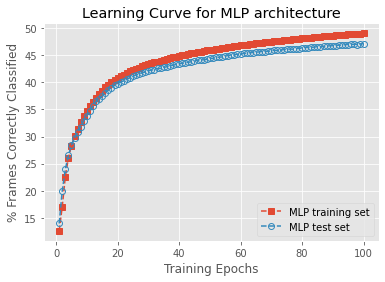

Training time:  532.2373199462891


In [ ]:
# Learning Curve

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig, ax = plt.subplots()
epochs = np.arange(1,nr_epochs+1)
ax.plot(epochs, epoch_info['correct_frames_train'], '--s', label='MLP training set')
ax.plot(epochs, epoch_info['correct_frames_test'], '--o', markerfacecolor='None', label='MLP test set')

training_time = epoch_info['trainig_duration'][0]
ax.set(xlabel='Training Epochs', ylabel='% Frames Correctly Classified',
       title='Learning Curve for MLP architecture')

learning_curve_filepath = root_path +'learning_curve_' + filename + '.png'
plt.legend()
fig.savefig(learning_curve_filepath)
plt.show()

